In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mat73
import pickle

import MARBLE
from MARBLE import plotting

from sklearn.decomposition import PCA

import neo
from elephant.statistics import instantaneous_rate
from elephant.kernels import GaussianKernel
from quantities import ms

In [2]:
# load data compiled into matlab cell array
!wget -nc https://dataverse.harvard.edu/api/access/datafile/6963157 -O data/conditions_spiking_data.mat
spiking_data = mat73.loadmat('data/conditions_spiking_data.mat')['all_results']

File ‘data/conditions_spiking_data.mat’ already there; not retrieving.


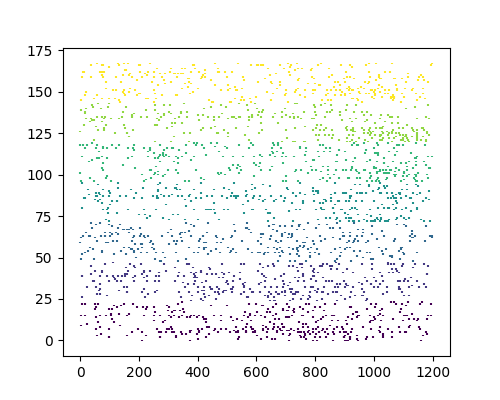

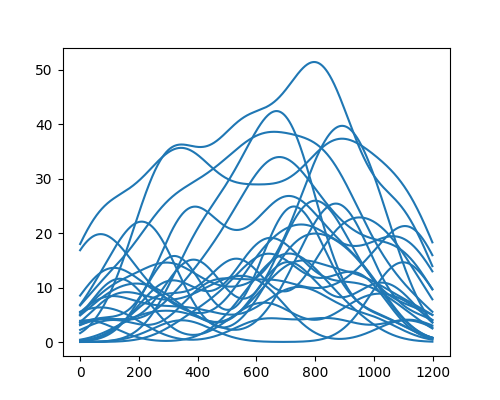

In [3]:
trial = 1
session = 9

spikes, colors = [], []
for cond in range(7):
    st = spiking_data[session][cond][trial][0][:,:]
    spikes += [np.where(st[ch,:])[0] for ch in range(24)]
    colors += [cm.viridis(cond / 6) for _ in range(24)]

_, ax = plt.subplots(figsize=(5,4))
ax.eventplot(spikes, color=colors)

_, ax = plt.subplots(figsize=(5,4))
gk = GaussianKernel(100 * ms) # increase this for smoother signals (previously used auto)

for sp in spikes[:24]:
    st = neo.SpikeTrain(sp, units='ms', t_stop=1200)
                        
    inst_rate = instantaneous_rate(st, kernel=gk, sampling_period=1 * ms).magnitude
    ax.plot(inst_rate, 'C0')

In [4]:
!wget -nc https://dataverse.harvard.edu/api/access/datafile/7062086 -O data/raw_data_session_9_3D.pkl
pos, vel, time, _ = pickle.load(open('data/raw_data_session_9_3D.pkl','rb'))

File ‘data/raw_data_session_9_3D.pkl’ already there; not retrieving.


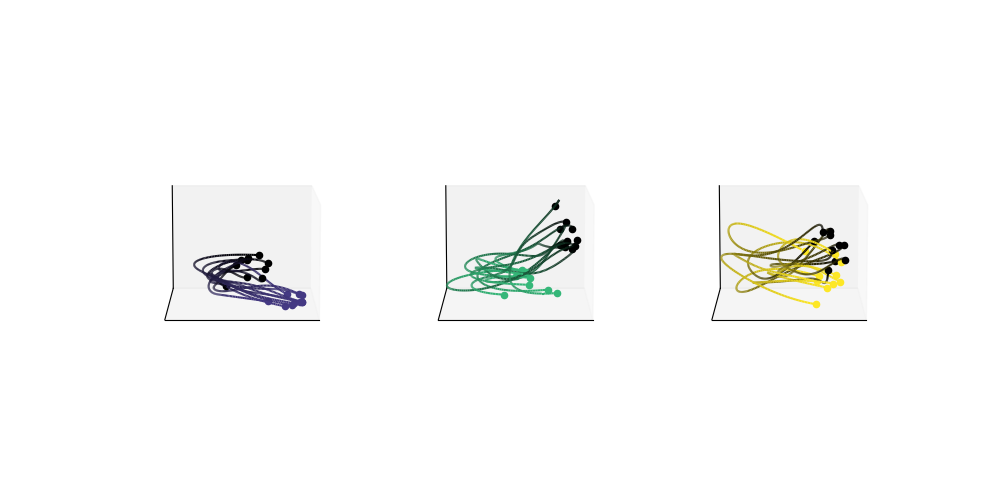

In [5]:
fig = plt.figure(figsize=(10,5))
n_traj=10
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d.art3d import Line3DCollection

for i,cond in enumerate([1,4,6]):
    ax = fig.add_subplot(int('13{}'.format(i+1)), projection='3d')
    ax.view_init(elev=10., azim=90)
    starts = np.where(time[cond]==0)[0]
    for j in range(n_traj):
        t = range(starts[j], starts[j+1]-1)
        p = pos[cond][t]
        segments = np.stack([p[:-1], p[1:]], axis=1)
        
        colors = [(0, 0, 0), cm.viridis(cond/6)] # first color is black, last is red
        cmap = LinearSegmentedColormap.from_list("Custom", colors, N=len(time[cond][t]))
        r = cmap(np.linspace(0,1,len(time[cond][t])))
        
        ax.add_collection(Line3DCollection(segments,colors=list(r)))
        ax.set_xlim([min(pos[cond][:,0]), max(pos[cond][:,0])])
        ax.set_ylim([min(pos[cond][:,1]), max(pos[cond][:,1])])
        ax.set_zlim([min(pos[cond][:,2]), max(pos[cond][:,2])])
        
        ax.scatter(pos[cond][starts[j],0],pos[cond][starts[j],1],pos[cond][starts[j],2],color=colors[0])
        ax.scatter(pos[cond][starts[j+1]-1,0],pos[cond][starts[j+1]-1,1],pos[cond][starts[j+1]-1,2],color=colors[1])
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.get_zaxis().set_ticks([])

In [6]:
data = MARBLE.construct_dataset(pos, features=vel, graph_type='cknn', k=10, stop_crit=0.05, local_gauges=False)

---- Embedding dimension: 3
---- Signal dimension: 3


---- Computing kernels ... Done 
---- Computing eigendecomposition ... Done 


/Users/arnaudon/base/lib/python3.10/site-packages/ipympl/backend_nbagg.py:336: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  self.figure.savefig(buf, format='png', dpi='figure')


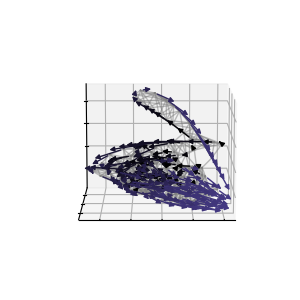

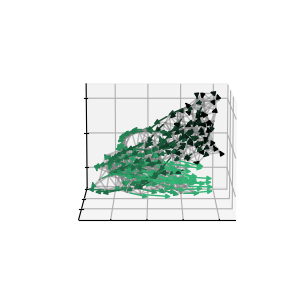

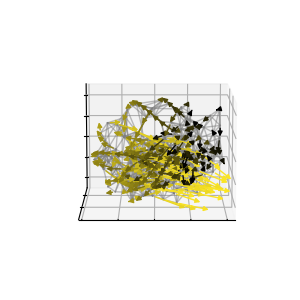

In [7]:
data_plot = data.to_data_list()
for i in [1,4,6]:
    d = data_plot[i]
    c = [(0, 0, 0), cm.viridis(i/6)] # first color is black, last is Ci
    cmap = LinearSegmentedColormap.from_list("Custom", c, N=140)
    ind = np.linspace(0,1,140)
    colors = cmap(ind[time[i][d.sample_ind].astype(int)])
    plotting.fields([d], view=(10,90), figsize=(3,3), scale=2, width=7., color=colors, axes_visible=False)
    plt.axis('on')